# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [31]:
objs = np.array([8., 2.])
objs /= np.sum(objs)
entropy = 0
for p in objs:
    entropy -= 0 if not p else p * np.log2(p)
entropy

0.7219280948873623

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [32]:
objs = np.array([8., 2.])
objs /= np.sum(objs)
gini = 0
for p in objs:
    gini += p * (1 - p)
gini

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [33]:
target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

mean_target = sum(target_values) / len(target_values)

print("Mean_target =", mean_target)  

Mean_target = 40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [34]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [36]:
import numpy as np
import pandas as pd
from typing import Union, Tuple

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    
    def _gini(y):
        counts = pd.Series(y).value_counts(normalize=True)
        return (counts * (1 - counts)).sum()
    
    def _dispersion(y):
        return pd.Series(y).std() ** 2
    
    def _information_gain(X, y, threshold):
        if feature_type == 'categorical':
            left = y[X == threshold]
            right = y[X != threshold]
        else:
            left = y[X <= threshold]
            right = y[X > threshold]
        
        if task == 'classification':
            S = _gini(y)
            S1 = _gini(left)
            S2 = _gini(right)
        else:
            S = _dispersion(y)
            S1 = _dispersion(left)
            S2 = _dispersion(right)
        
        n = len(y)
        ig = S - (len(left)/n)*S1 - (len(right)/n)*S2
        return ig if not np.isnan(ig) else 0

    unique = np.unique(feature_vector)
    
    if feature_type == 'real':
        thresholds = (unique[1:] + unique[:-1]) / 2
    else:
        thresholds = unique

    if len(unique) <= 1:
        return np.array([]), np.array([]), 0.0, 0.0

    X_series = pd.Series(feature_vector)
    y_series = pd.Series(target_vector)
    
    criterions = np.array([_information_gain(X_series, y_series, t) for t in thresholds])

    best_idx = np.argmax(criterions)
    return thresholds, criterions, thresholds[best_idx], criterions[best_idx]


Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [ ]:
!pip3 install scikit-learn==1.0.2

In [37]:
from fairlearn.datasets import fetch_boston
X, y = fetch_boston(return_X_y=True)

thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), y,
    task="regression", feature_type="real"
)


c:\Users\ilya.terentyev\AppData\Local\anaconda3\Lib\site-packages\fairlearn\datasets\_fetch_boston.py:133: DataFairnessWarning: You are about to use a dataset with known fairness issues.
  warnings.warn(DataFairnessWarning(msg))


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

c:\Users\ilya.terentyev\AppData\Local\anaconda3\Lib\site-packages\fairlearn\datasets\_fetch_boston.py:133: DataFairnessWarning: You are about to use a dataset with known fairness issues.
  warnings.warn(DataFairnessWarning(msg))


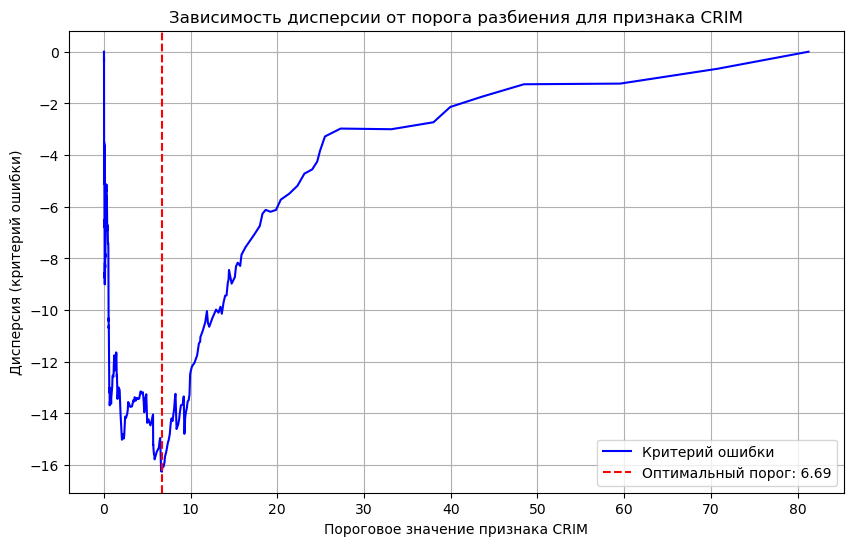

Оптимальный порог: 6.6863
Минимальная дисперсия: -16.2598


In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Получаем данные
X, y = fetch_boston(return_X_y=True)
X = pd.DataFrame(X, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
y = pd.Series(y)

# Находим оптимальное разбиение
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].values,
    y.values,
    task="regression",
    feature_type="real"
)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(thresholds, -np.array(variances), 'b-', label='Критерий ошибки')
plt.axvline(x=threshold_best, color='r', linestyle='--', label=f'Оптимальный порог: {threshold_best:.2f}')
plt.xlabel('Пороговое значение признака CRIM')
plt.ylabel('Дисперсия (критерий ошибки)')
plt.title('Зависимость дисперсии от порога разбиения для признака CRIM')
plt.legend()
plt.grid(True)
plt.show()

# Выводим оптимальные значения
print(f"Оптимальный порог: {threshold_best:.4f}")
print(f"Минимальная дисперсия: {-variance_best:.4f}")

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [39]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        if node["type"] == "terminal":
            return node["class"]
        
        feature = node["feature_split"]
        if self._feature_types[feature] == "real":
            if x[feature] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])
        else:
            if x[feature] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

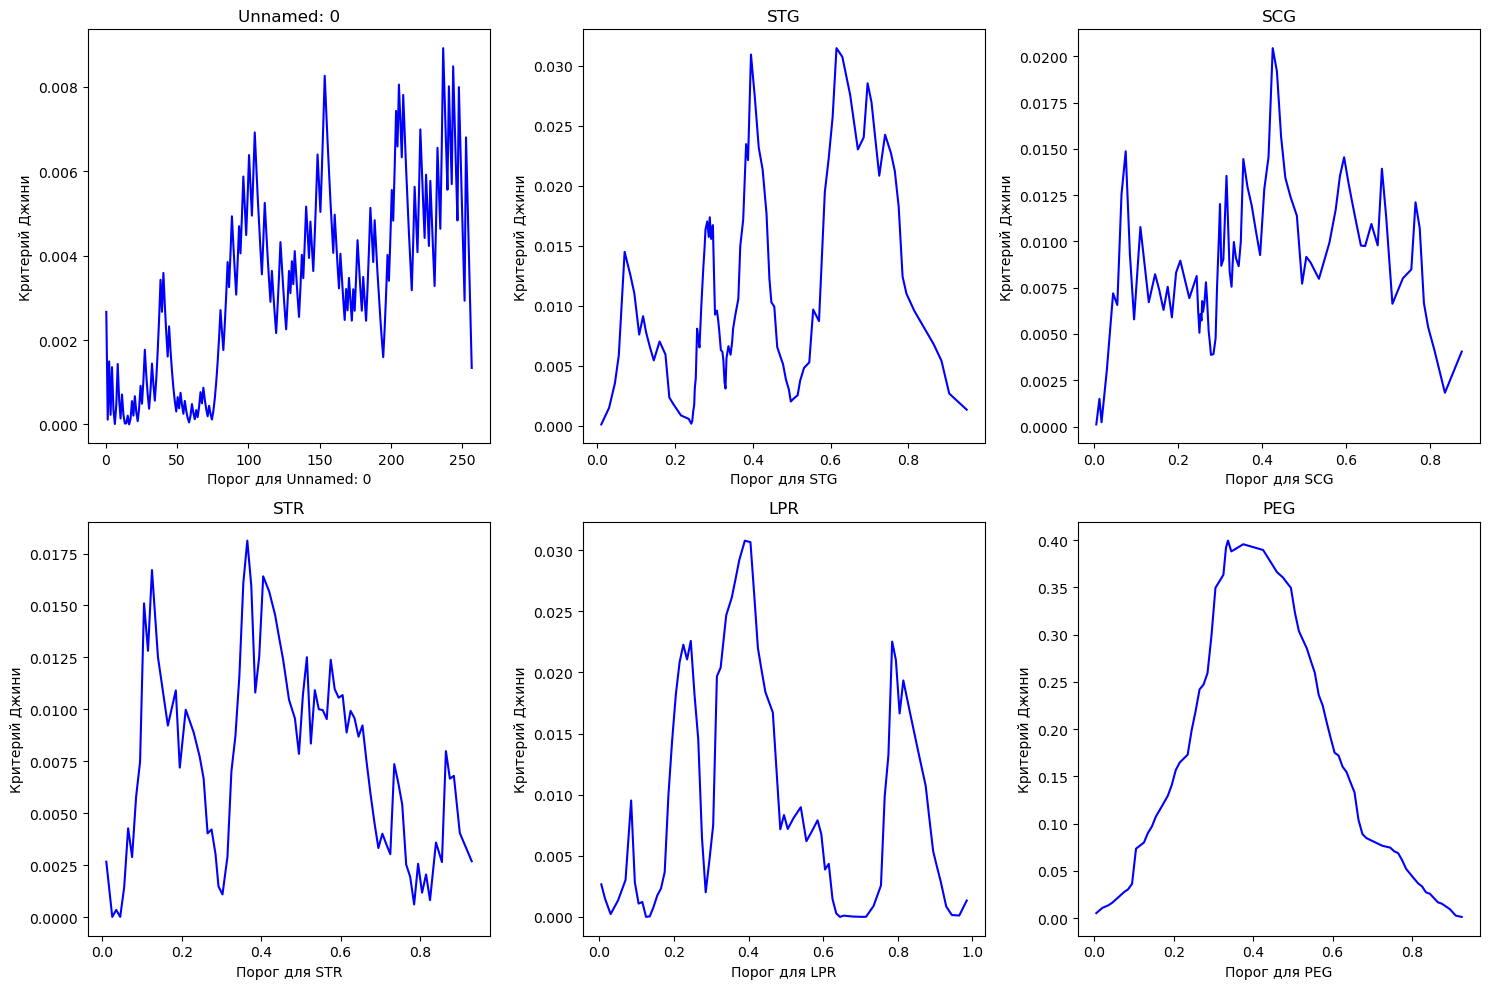

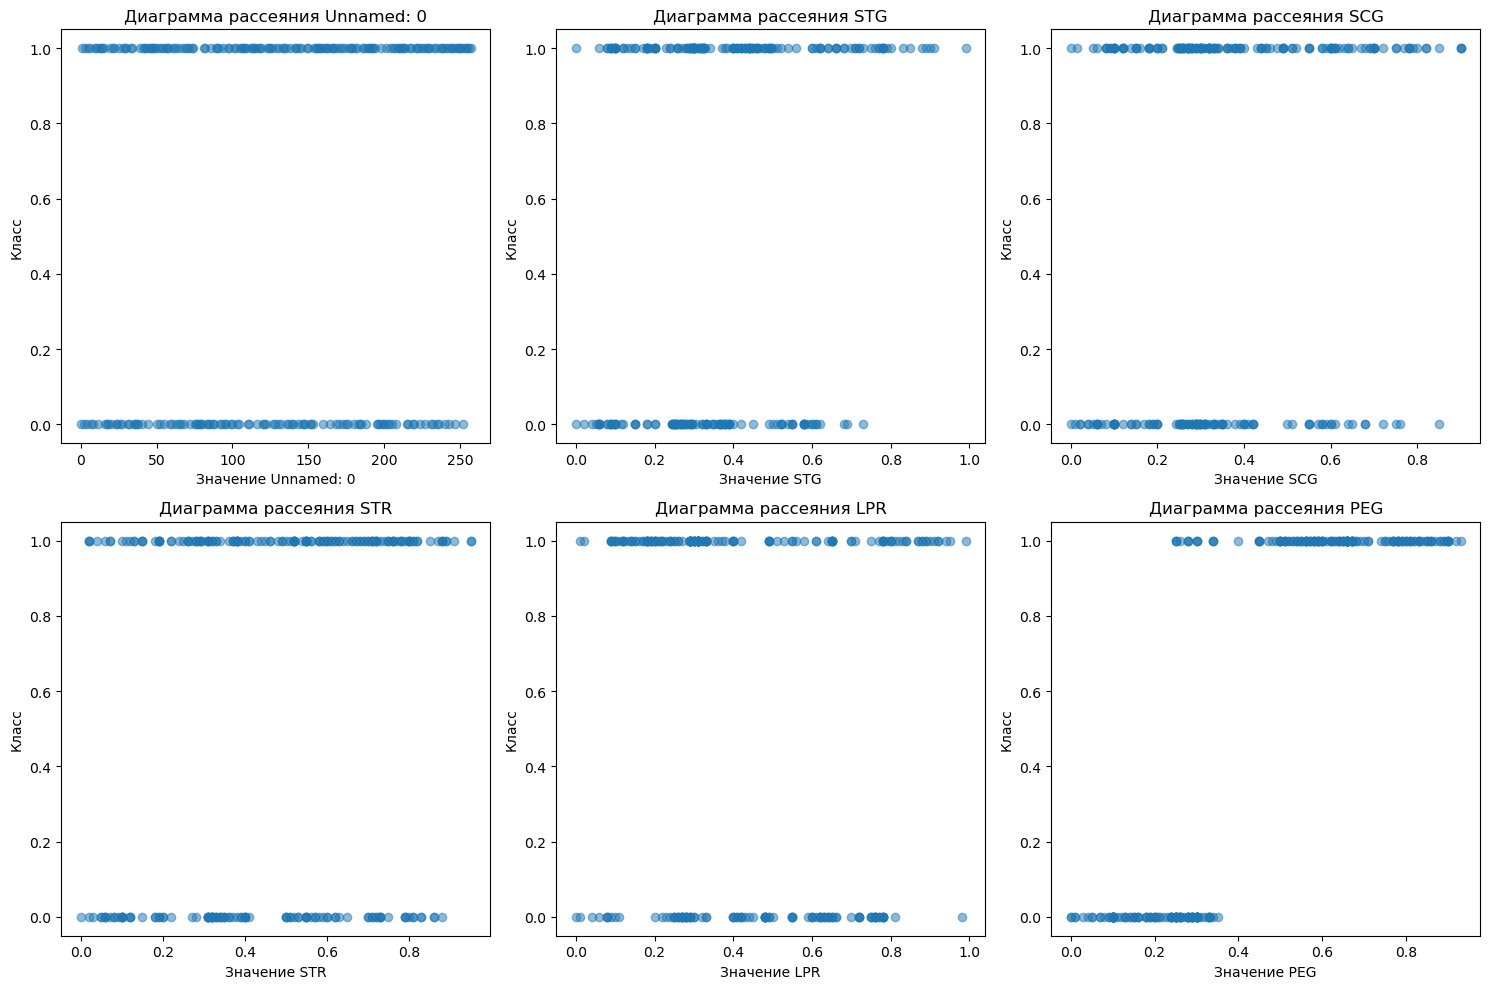

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

students = pd.read_csv('students.csv')
X = students.iloc[:, :-1]
y = students.iloc[:, -1]
features = X.columns

plt.figure(figsize=(15, 10))

# Для каждого признака строим кривую "порог - критерий Джини"
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    feature_values = X[feature].values
    thresholds, ginis, _, _ = find_best_split(feature_values, y.values, 
                                            task="classification", 
                                            feature_type="real")
    plt.plot(thresholds, ginis, 'b-')
    plt.xlabel(f'Порог для {feature}')
    plt.ylabel('Критерий Джини')
    plt.title(f'{feature}')

plt.tight_layout()
plt.show()

# Создаем диаграммы рассеяния
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.scatter(X[feature], y, alpha=0.5)
    plt.xlabel(f'Значение {feature}')
    plt.ylabel('Класс')
    plt.title(f'Диаграмма рассеяния {feature}')

plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Оптимальный признак для разбиения - PEG (успешность на экзаменах), так как он демонстрирует наивысшее значение критерия Джини среди всех признаков.

Согласованность с визуализацией: диаграммы рассеяния подтверждают этот выбор, показывая четкую зависимость - пользователи с низкими результатами экзаменов (PEG) преимущественно относятся к классу 0 (низкий уровень знаний).

Характеристика хороших признаков:

График Джини имеет выраженную параболическую форму

Наблюдается четкий максимум с высоким значением критерия

Явно прослеживается точка оптимального разделения

Характеристика слабых признаков:

Кривая Джини практически плоская

Угол наклона графика минимален относительно оси X

Отсутствует выраженный максимум критерия

Разделение классов незначительное

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [41]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = ['class'] + [f'feature_{i}' for i in range(1, 23)]
data = pd.read_csv(url, header=None, names=columns)

le = LabelEncoder()
for col in data.columns:
    data[col] = le.fit_transform(data[col])

X = data.drop('class', axis=1).values
y = data['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]  # Все признаки категориальные
tree = DecisionTree(feature_types=feature_types, task='classification')
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [19]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [20]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

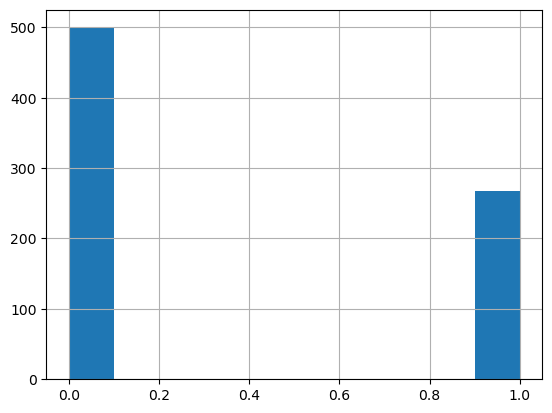

In [21]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

Размеры выборок:
Обучающая-обучающая: 375 (0.49 от исходного)
Обучающая-валидационная: 162 (0.21 от исходного)
Тестовая: 231 (0.30 от исходного)


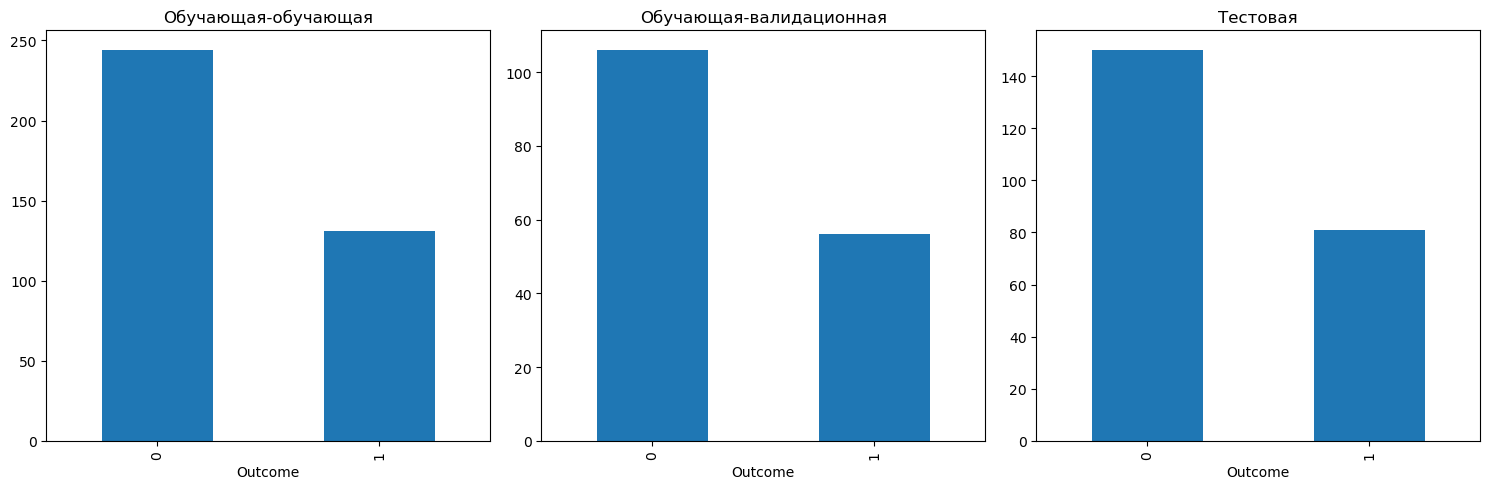

In [22]:
from sklearn.model_selection import train_test_split

X = data.drop('Outcome', axis=1)  
y = data['Outcome']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,  
    stratify=y  
)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train,
    test_size=0.3,
    random_state=42,
    stratify=y_train
)

print("Размеры выборок:")
print(f"Обучающая-обучающая: {len(X_train_train)} ({len(X_train_train)/len(X):.2f} от исходного)")
print(f"Обучающая-валидационная: {len(X_train_val)} ({len(X_train_val)/len(X):.2f} от исходного)")
print(f"Тестовая: {len(X_test)} ({len(X_test)/len(X):.2f} от исходного)")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
y_train_train.value_counts().plot(kind='bar', ax=ax1, title='Обучающая-обучающая')
y_train_val.value_counts().plot(kind='bar', ax=ax2, title='Обучающая-валидационная')
y_test.value_counts().plot(kind='bar', ax=ax3, title='Тестовая')
plt.tight_layout()
plt.show()

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

max_depth_values = [3, 5, 7, 10, 15, 20, None]
min_samples_leaf_values = [1, 2, 3, 5, 7, 10]

best_f1 = 0
best_params = {}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
        model.fit(X_train_train, y_train_train)
        
        y_pred = model.predict(X_train_val)
        current_f1 = f1_score(y_train_val, y_pred)

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_params = {
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf
            }

print(f"Лучшие параметры: {best_params}")
print(f"Лучшая F1-мера на валидации: {best_f1:.4f}")

final_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
final_model.fit(X_train, y_train)  

y_test_pred = final_model.predict(X_test)
y_test_proba = final_model.predict_proba(X_test)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'AUC-ROC': roc_auc_score(y_test, y_test_proba)
}

print("\nМетрики на тестовой выборке:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 1}
Лучшая F1-мера на валидации: 0.5455

Метрики на тестовой выборке:
Accuracy: 0.7662
Precision: 0.8000
Recall: 0.4444
AUC-ROC: 0.8182


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [24]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=best_params['max_depth'],
        min_samples_leaf=best_params['min_samples_leaf']
    ),
    n_estimators=50,
    random_state=42
)

bagging_model.fit(X_train, y_train)

y_test_pred_bag = bagging_model.predict(X_test)
y_test_proba_bag = bagging_model.predict_proba(X_test)[:, 1]

metrics_bag = {
    'Accuracy': accuracy_score(y_test, y_test_pred_bag),
    'Precision': precision_score(y_test, y_test_pred_bag),
    'Recall': recall_score(y_test, y_test_pred_bag),
    'AUC-ROC': roc_auc_score(y_test, y_test_proba_bag)
}

print("\nМетрики BaggingClassifier на тестовой выборке:")
for name, value in metrics_bag.items():
    print(f"{name}: {value:.4f}")

print("\nСравнение с DecisionTreeClassifier:")
for name in metrics.keys():
    improvement = metrics_bag[name] - metrics[name]
    print(f"{name}: {metrics[name]:.4f} -> {metrics_bag[name]:.4f} ({improvement:+.4f})")


Метрики BaggingClassifier на тестовой выборке:
Accuracy: 0.7619
Precision: 0.6970
Recall: 0.5679
AUC-ROC: 0.8362

Сравнение с DecisionTreeClassifier:
Accuracy: 0.7662 -> 0.7619 (-0.0043)
Precision: 0.8000 -> 0.6970 (-0.1030)
Recall: 0.4444 -> 0.5679 (+0.1235)
AUC-ROC: 0.8182 -> 0.8362 (+0.0180)


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf = RandomForestClassifier(
    n_estimators=50,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,  
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

best_rf_params = grid_search.best_params_
print(f"Лучшие параметры Random Forest: {best_rf_params}")
print(f"Лучшая F1-мера при кросс-валидации: {grid_search.best_score_:.4f}")

final_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    random_state=42
)
final_rf.fit(X_train, y_train)

y_test_pred_rf = final_rf.predict(X_test)
y_test_proba_rf = final_rf.predict_proba(X_test)[:, 1]

metrics_rf = {
    'Accuracy': accuracy_score(y_test, y_test_pred_rf),
    'Precision': precision_score(y_test, y_test_pred_rf),
    'Recall': recall_score(y_test, y_test_pred_rf),
    'AUC-ROC': roc_auc_score(y_test, y_test_proba_rf)
}

print("\nМетрики Random Forest на тестовой выборке:")
for name, value in metrics_rf.items():
    print(f"{name}: {value:.4f}")

print("\nСравнение всех моделей:")
models = {
    'Decision Tree': metrics,
    'Bagging': metrics_bag,
    'Random Forest': metrics_rf
}

for model_name, model_metrics in models.items():
    print(f"\n{model_name}:")
    for metric_name, value in model_metrics.items():
        print(f"{metric_name}: {value:.4f}")

Лучшие параметры Random Forest: {'max_depth': 20, 'min_samples_split': 10}
Лучшая F1-мера при кросс-валидации: 0.6334

Метрики Random Forest на тестовой выборке:
Accuracy: 0.7403
Precision: 0.6567
Recall: 0.5432
AUC-ROC: 0.8207

Сравнение всех моделей:

Decision Tree:
Accuracy: 0.7662
Precision: 0.8000
Recall: 0.4444
AUC-ROC: 0.8182

Bagging:
Accuracy: 0.7619
Precision: 0.6970
Recall: 0.5679
AUC-ROC: 0.8362

Random Forest:
Accuracy: 0.7403
Precision: 0.6567
Recall: 0.5432
AUC-ROC: 0.8207


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

n_estimators:   1 | AUC-ROC: 0.6837
n_estimators:   5 | AUC-ROC: 0.7311
n_estimators:  10 | AUC-ROC: 0.7793
n_estimators:  20 | AUC-ROC: 0.8056
n_estimators:  30 | AUC-ROC: 0.8185
n_estimators:  40 | AUC-ROC: 0.8216
n_estimators:  50 | AUC-ROC: 0.8207
n_estimators:  75 | AUC-ROC: 0.8205
n_estimators: 100 | AUC-ROC: 0.8187
n_estimators: 150 | AUC-ROC: 0.8222
n_estimators: 200 | AUC-ROC: 0.8253


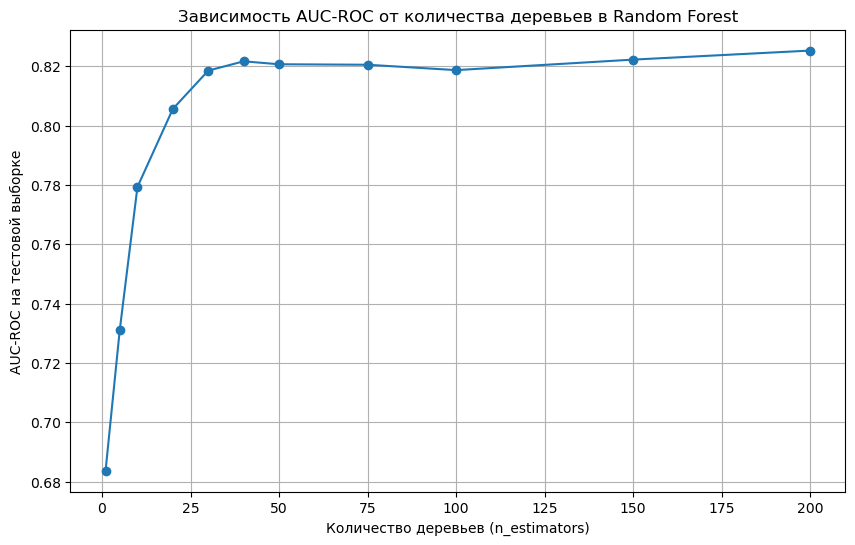

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

n_estimators_range = [1, 5, 10, 20, 30, 40, 50, 75, 100, 150, 200]

auc_scores = []

for n in n_estimators_range:
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_rf_params['max_depth'],
        min_samples_split=best_rf_params['min_samples_split'],
        random_state=42
    )
    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)
    print(f"n_estimators: {n:3d} | AUC-ROC: {auc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_scores, marker='o')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('AUC-ROC на тестовой выборке')
plt.title('Зависимость AUC-ROC от количества деревьев в Random Forest')
plt.grid(True)
plt.show()

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

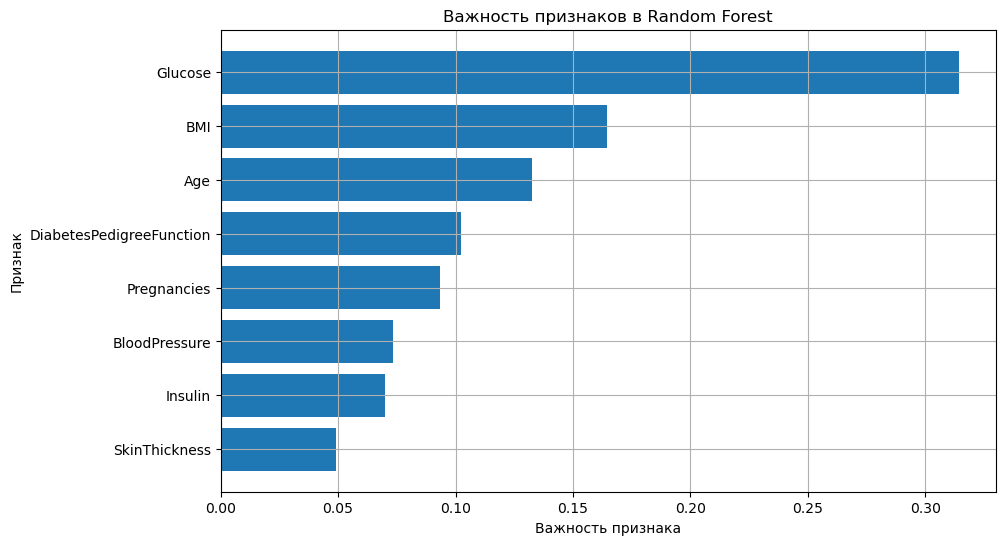


Самый важный признак для определения диабета: Glucose
Его важность: 0.3142


In [27]:
feature_importances = final_rf.feature_importances_
features = X_train.columns

sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в Random Forest')
plt.gca().invert_yaxis()  
plt.grid(True)
plt.show()

most_important_feature = sorted_features[0]
print(f"\nСамый важный признак для определения диабета: {most_important_feature}")
print(f"Его важность: {sorted_importances[0]:.4f}")